## 0. Install and Import Dependencies

In [ ]:
!pip install easyocr #安裝easyocr
!pip install imutils #安裝imutils

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
from google.colab.patches import cv2_imshow #導入需要的元件


## 1. Read in Image, Grayscale and Blur

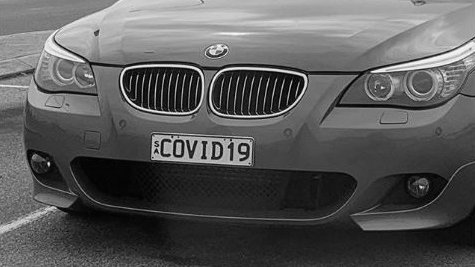

In [ ]:
img = cv2.imread('image2.jpg') #讀入image2.jpg
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #轉為灰階
cv2_imshow(gray)

## 2. Apply filter and find edges for localization

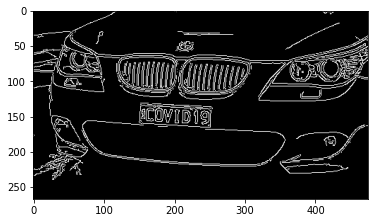

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction 去噪 用二邊過濾化過濾，用兩個值去雜訊(過濾) bilateralFilter值可以改
edged = cv2.Canny(bfilter, 30, 200) #Edge detection #用canny找出邊緣  Canny值可以改
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #找出Contours
contours = imutils.grab_contours(keypoints) #找出Contours的點(框)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] #找後十個

In [ ]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True) #找出大概是四方形的點 #10(輪廓值)可以改成別的
    if len(approx) == 4: #找四方形
        location = approx #如果找到就將location存起來
        break

In [ ]:
location #秀出location

array([[[152, 136]],

       [[248, 139]],

       [[251, 164]],

       [[153, 160]]], dtype=int32)

In [ ]:
mask = np.zeros(gray.shape, np.uint8) #做出mask
new_image = cv2.drawContours(mask, [location], 0,255, -1) #劃出Contours
new_image = cv2.bitwise_and(img, img, mask=mask) #用bitwise_and蓋出車牌

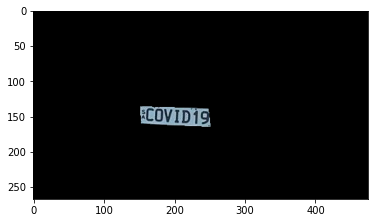

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)) #色彩空間轉化，BGR轉成RGB

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y)) #用四個點的值切出車牌
cropped_image = gray[x1:x2+1, y1:y2+1]

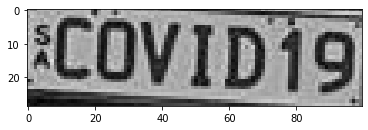

In [ ]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)) #色彩空間轉化，BGR轉成RGB

## 4. Use Easy OCR To Read Text

In [ ]:
reader = easyocr.Reader(['en']) #呼叫easyocr 設定en
result = reader.readtext(cropped_image) #將值丟入easyocr做辨識
result

[([[0, 0], [100, 0], [100, 29], [0, 29]], 'ICOVIDT9', 0.5350358172081381)]

## 5. Render Result

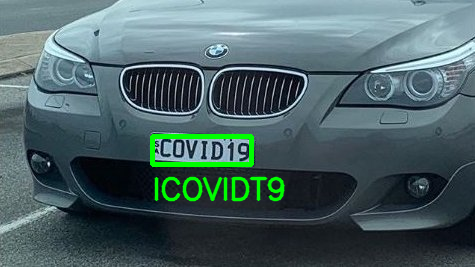

In [ ]:
text = result[0][-2] 
font = cv2.FONT_HERSHEY_SIMPLEX #使用各種字體
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA) #定義及放入文字
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3) #畫文字與框框的參數
# plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
cv2_imshow(res)